# Burgers Equation with Differentiable Physics (DP)

In [45]:
%reset -f

# from phi.tf.flow import *
from phi.jax.flow import *
# from phi.torch.flow import *
import numpy as np

import pylab as plt
from utils import plot

## Set up the constants

In [46]:
N = 128
DX = 2/N
STEPS = 32
DT = 1/STEPS
NU = 0.01/(N*np.pi)

# allocate velocity grid
velocity = CenteredGrid(0, extrapolation.PERIODIC, x=N, bounds=Box['x', -1:1])

# and a grid with the reference solution
REFERENCE_DATA = math.tensor([0.008612174447657694, 0.02584669669548606, 0.043136357266407785, 0.060491074685516746, 0.07793926183951633, 0.0954779141740818, 0.11311894389663882, 0.1308497114054023, 0.14867023658641343, 0.1665634396808965, 0.18452263429574314, 0.20253084411376132, 0.22057828799835133, 0.23865132431365316, 0.25673879161339097, 0.27483167307082423, 0.2929182325574904, 0.3109944766354339, 0.3290477753208284, 0.34707880794585116, 0.36507311960102307, 0.38303584302507954, 0.40094962955534186, 0.4188235294008765, 0.4366357052408043, 0.45439856841363885, 0.4720845505219581, 0.4897081943759776, 0.5072391070000235, 0.5247011051514834, 0.542067187709797, 0.5593576751669057, 0.5765465453632126, 0.5936507311857876, 0.6106452944663003, 0.6275435911624945, 0.6443221318186165, 0.6609900633731869, 0.67752574922899, 0.6939334022562877, 0.7101938106059631, 0.7263049537163667, 0.7422506131457406, 0.7580207366534812, 0.7736033721649875, 0.7889776974379873, 0.8041371279965555, 0.8190465276590387, 0.8337064887158392, 0.8480617965162781, 0.8621229412131242, 0.8758057344502199, 0.8891341984763013, 0.9019806505391214, 0.9143881632159129, 0.9261597966464793, 0.9373647624856912, 0.9476871303793314, 0.9572273019669029, 0.9654367940878237, 0.9724097482283165, 0.9767381835635638, 0.9669484658390122, 0.659083299684951, -0.659083180712816, -0.9669485121167052, -0.9767382069792288, -0.9724097635533602, -0.9654367970450167, -0.9572273263645859, -0.9476871280825523, -0.9373647681120841, -0.9261598056102645, -0.9143881718456056, -0.9019807055316369, -0.8891341634240081, -0.8758057205293912, -0.8621229450911845, -0.8480618138204272, -0.833706571569058, -0.8190466131476127, -0.8041372124868691, -0.7889777195422356, -0.7736033858767385, -0.758020740007683, -0.7422507481169578, -0.7263049162371344, -0.7101938950789042, -0.6939334061553678, -0.677525822052029, -0.6609901538934517, -0.6443222327338847, -0.6275436932970322, -0.6106454472814152, -0.5936507836778451, -0.5765466491708988, -0.5593578078967361, -0.5420672759411125, -0.5247011730988912, -0.5072391580614087, -0.4897082914472909, -0.47208460952428394, -0.4543985995006753, -0.4366355580500639, -0.41882350871539187, -0.40094955631843376, -0.38303594105786365, -0.36507302109186685, -0.3470786936847069, -0.3290476440540586, -0.31099441589505206, -0.2929180880304103, -0.27483158663081614, -0.2567388003912687, -0.2386513127155433, -0.22057831776499126, -0.20253089403524566, -0.18452269630486776, -0.1665634500729787, -0.14867027528284874, -0.13084990929476334, -0.1131191325854089, -0.09547794429803691, -0.07793928430794522, -0.06049114408297565, -0.0431364527809777, -0.025846763281087953, -0.00861212501518312] , math.spatial('x'))

SOLUTION_T16 = CenteredGrid( REFERENCE_DATA, extrapolation.PERIODIC, x=N, bounds=Box['x',-1:1])

## Set up loss function
Let's define the loss function. Let's not forget to jit-compile the function. Only problem is, jit-compilation treates global variables (e.g. `velocities`) like implicit arguments to the function, i.e. they are not modified ! The velocities list will always be empty: remember that when plotting `velocities[16]`!

In [47]:
velocities = []

# @math.jit_compile
def loss_fn(vel0, ref):
    velocities.append(vel0)
    for time_step in range(STEPS):
        v1 = diffuse.explicit(1.0*velocities[-1], NU, DT, substeps=1)
        v2 = advect.semi_lagrangian(v1, v1, DT)
        velocities.append(v2)
    return field.l2_loss(velocities[16] - ref) * 2 / N

grad_fn = math.functional_gradient(loss_fn, wrt='vel0', get_output=True)
loss, grad = grad_fn(velocity, SOLUTION_T16)

print('Loss:', loss, '   Grad:', grad)

Loss: 0.38291526    Grad: CenteredGrid[(xˢ=128), size=(x=2) int64, extrapolation=periodic]


Let's plot the gradient of the loss w.r.t. the initial velocity. Because our initial guess too bad (equal to $0$), we see that the gradient is basically the opposite of what the initial velocity should be (assuming we don't consider the norm).

N.B. With the JAX backend, when converting a Tensor (e.g. `velocities[16].values.numpy('x')`) to numpy, if it fails, then use `velocities[16].values.native().primal`. Of course, we would need different abstractions for TORCH and TF backends.

<AxesSubplot: >

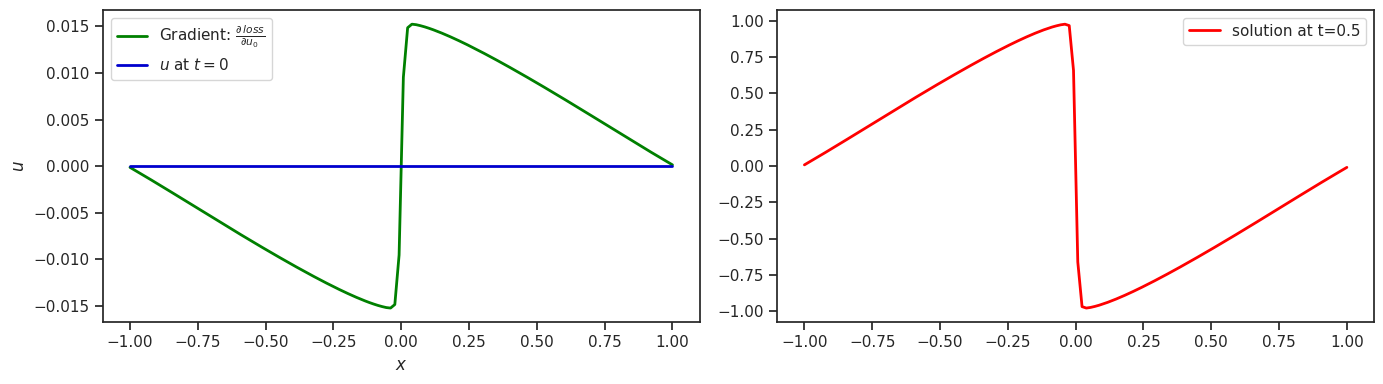

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7*2, 4))

# first gradient
pltx = np.linspace(-1,1,N)
plot(pltx, grad.values.numpy('x') , color='green', label=r"Gradient: $\frac{\partial \, loss}{\partial {u_0}}$", ax=ax1)
plot(pltx, velocity.values.numpy('x'), color='mediumblue', label=r"$u$ at $t=0$", ax=ax1, x_label=r'$x$', y_label=r'$u$', y_scale='linear')

# # some (optional) other fields to plot
# plot(pltx, velocities[16].values.native().primal , lw=2, color='cyan', label="u at t=0.5", ax=ax2, x_label=r'$x$', y_label=r'$u$')
plot(pltx, SOLUTION_T16.values.numpy('x'), color='red', label="solution at t=0.5", ax=ax2)
# plot(pltx, (velocities[16] - SOLUTION_T16).values.native().primal , lw=2, color='blue', label="difference at t=0.5", ax=ax2);

## Optimisation

In [49]:
LR = 5.
steps = 50
grads=[]

for optim_step in range(steps):
    velocities = []
    loss, grad = grad_fn(velocity, SOLUTION_T16)
    grads.append(grad)
    velocity = velocity - LR * grads[-1]
    print('Optimization step %d , loss: %f ' % (optim_step,loss))

Optimization step 0 , loss: 0.382915 
Optimization step 1 , loss: 0.326882 
Optimization step 2 , loss: 0.281032 
Optimization step 3 , loss: 0.242804 
Optimization step 4 , loss: 0.210666 
Optimization step 5 , loss: 0.183476 
Optimization step 6 , loss: 0.160343 
Optimization step 7 , loss: 0.140563 
Optimization step 8 , loss: 0.123572 
Optimization step 9 , loss: 0.108916 
Optimization step 10 , loss: 0.096224 
Optimization step 11 , loss: 0.085384 
Optimization step 12 , loss: 0.076139 
Optimization step 13 , loss: 0.068093 
Optimization step 14 , loss: 0.061025 
Optimization step 15 , loss: 0.054792 
Optimization step 16 , loss: 0.049286 
Optimization step 17 , loss: 0.044414 
Optimization step 18 , loss: 0.040104 
Optimization step 19 , loss: 0.036249 
Optimization step 20 , loss: 0.032819 
Optimization step 21 , loss: 0.029755 
Optimization step 22 , loss: 0.027011 
Optimization step 23 , loss: 0.024544 
Optimization step 24 , loss: 0.022328 
Optimization step 25 , loss: 0.0203

## Evaluation

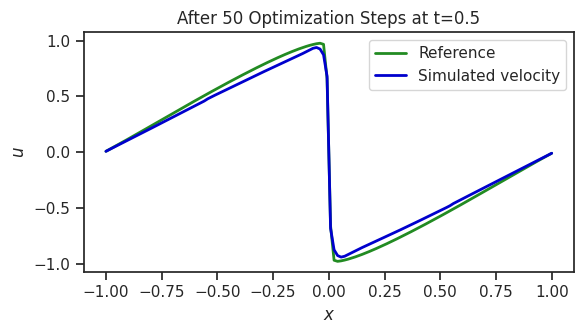

In [50]:
# target constraint at t=0.5
ax = plot(pltx, SOLUTION_T16.values.numpy('x'), color='forestgreen', label="Reference", x_label=r'$x$')

# optimized state of our simulation after 16 steps
plot(pltx, velocities[16].values.native().primal, color='mediumblue', ax=ax, label="Simulated velocity", title="After "+str(steps)+" Optimization Steps at t=0.5", x_label=r'$x$', y_label=r'$u$');

<AxesSubplot: title={'center': 'After 50 Optimization Steps at t=0.5'}, xlabel='$x$'>

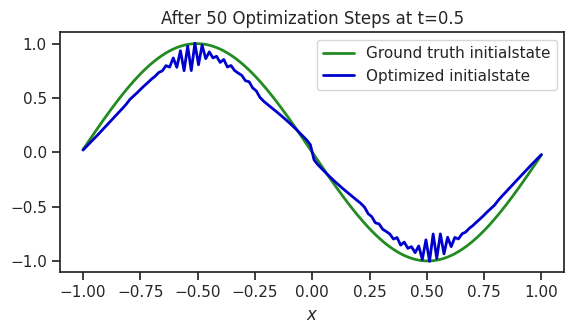

In [51]:
# ground truth state at time=0 , move down
INITIAL_GT = np.asarray( [-np.sin(np.pi * x) for x in np.linspace(-1+DX/2,1-DX/2,N)] ) # 1D numpyarray
ax = plot(pltx, INITIAL_GT.flatten() , lw=2, color='forestgreen', label="Ground truth initial state") # ground truth initial state of sim
plot(pltx, velocity.values.numpy('x'), lw=2, color='mediumblue', label="Optimized initial state", title="After "+str(steps)+" Optimization Steps at t=0.5", x_label=r'$x$', ax=ax) # manual

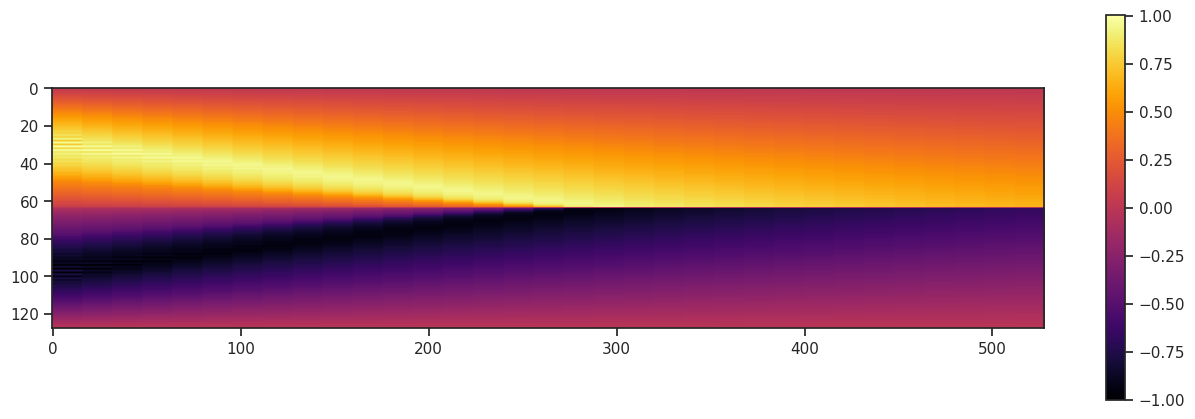

In [62]:
import pylab

def show_state(a):
    a=np.expand_dims(a, axis=2)
    for i in range(4):
        a = np.concatenate( [a,a] , axis=2)
    a = np.reshape( a, [a.shape[0],a.shape[1]*a.shape[2]] )
    fig, axes = pylab.subplots(1, 1, figsize=(16, 5))
    im = axes.imshow(a, origin='upper', cmap='inferno')
    pylab.colorbar(im)

# get numpy versions of all states
vels = [ x.values.native().primal[:, jnp.newaxis] for x in velocities]
# concatenate along vector/features dimension
vels = np.concatenate(vels, axis=-1)

# save for comparison with other methods
import os; os.makedirs("./temp",exist_ok=True)
np.savez_compressed("./temp/burgers-diffphys-solution.npz", np.reshape(vels,[N,STEPS+1])) # removebatch & channel dimension

show_state(vels)

## Findings
- DP is much more efficient than PINN, because of clearer gradients
- Phiflow allows computing gradients much like in jax, not like presented in the book
- JIT compilation is possible, and much faster, but with a cost of not colelcting the velocities in a list (global variable)